# PINN: Singularly perturbed boundary value problem


In [1]:
!pip install torchaudio==0.13.0
!pip install torchvision==0.14.0
!pip install torchphysics

import torch
import torchphysics as tp
import math

In [2]:
X = tp.spaces.R1('x')
Y = tp.spaces.R1('y')

D = tp.spaces.R2('D')

U = tp.spaces.R1('u')

In [3]:
h, w = 1, 1
eps = 0.1
R =-2

In [4]:

Ix = tp.domains.Interval(X, 0, w)
Iy = tp.domains.Interval(Y, 0, h)

A_xy = Ix * Iy
A_D = tp.domains.Parallelogram(D, [-1,-1], [-1.0,1], [1,-1.0])

Before we visualize the created domain, we create Sampler objects which are iterators that sample points from the domain during the optimization task. There are again various options to sample from the domains, an easy way would be to sample uniformly distributed random points. In this example, we choose an adaptive sampler to sample points in the inner of the domain. It will sample more points in points where the loss is large.

The amount of sampled points is defined by their density in the 3/2-dim subset, it could be increased to achieve better training results.

In [5]:
#inner_sampler = tp.samplers.AdaptiveRandomRejectionSampler(A_x*A_t*A_D, density=2)
inner_sampler = tp.samplers.RandomUniformSampler(A_xy*A_D, n_points = 100000)
torch.cuda.is_available()

True

We visualize the domain through the points created by the samplers using matplotlib:

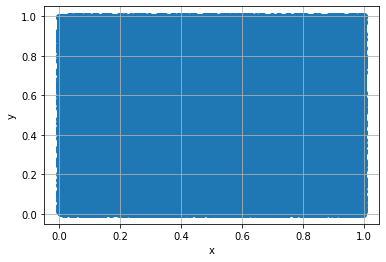

In [6]:
fig = tp.utils.scatter(X*Y, inner_sampler)

In [7]:
# apply boundary condition via hard constrains:
def constrain_fn(u,x,y):   
    u_con =  u *(x-w)/w * x/w * (y-h)/h *y/h
   
    return u_con

In the next step we define the NN-model we want to fit to the PDE. A normalization can improve convergence for large or small domains.

In [8]:
model = tp.models.Sequential(
    tp.models.NormalizationLayer(A_xy*A_D),
    tp.models.FCN(input_space=X*Y*D, output_space=U, hidden=(60, 60, 60, 60, 60 ), xavier_gains=[5/3,5/3,5/3,5/3,0])
    #tp.models.QRES(input_space=X*Y*D, output_space=U, hidden=(50,50,50),xavier_gains=[5/3,5/3,0])
)
#if NN: 
#    model.load_state_dict(torch.load('PDE.pt')) #PDE_final; PDE_min_loss

Now, we define a condition which aims to minimze the mean squared error of the residual of the poisson equation. 

In [9]:
def pde_residual(u, x, y, D):
    u = constrain_fn(u,x,y)
    u_grad = tp.utils.grad(u, x, y)
    conv_term = torch.sum(D*tp.utils.grad(u, x, y), dim=1, keepdim=True)
    lap = tp.utils.laplacian(u, x, y, grad=u_grad)
    return -eps*lap - conv_term + R 
    
pde_condition_1 = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=pde_residual,
                                            name='pde_condition_1')

Finally, we optimize the conditions using a pytorch-lightning.LightningModule Solver and running the training. In the Solver, the training and validation conditions, as well as all optimizer options can be specified.

In [10]:
optim = tp.solver.OptimizerSetting(torch.optim.Adam, lr=1e-3)
#optim = tp.solver.OptimizerSetting(torch.optim.LBFGS, lr=1e-2)#SGD, LBFGS
solver = tp.solver.Solver([pde_condition_1], optimizer_setting = optim)

import pytorch_lightning as pl


trainer = pl.Trainer(gpus = 1 if torch.cuda.is_available else None,
                     max_steps=15000,
                     benchmark=True,
                     logger=True)
                     #checkpoint_callback=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 15.0 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
15.0 K    Trainable params
0         Non-trainable params
15.0 K    Total params
0.060     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/inu2sh/.conda/envs/TorchPhysics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/inu2sh/.conda/envs/TorchPhysics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Finally, we plot the obtained solution:

In [23]:
optim = tp.solver.OptimizerSetting(torch.optim.Adam, lr=1e-4)
#optim = tp.solver.OptimizerSetting(torch.optim.LBFGS, lr=1e-3)
#optim = tp.solver.OptimizerSetting(torch.optim.LBFGS, lr=1e-2)#SGD, LBFGS
solver = tp.solver.Solver([pde_condition_1], optimizer_setting = optim)

import pytorch_lightning as pl


trainer = pl.Trainer(gpus=0 if torch.cuda.is_available else None,
                     max_steps=100,
                     benchmark=True,
                     logger=True)
                     #checkpoint_callback=False)
trainer.fit(solver)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 15.0 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
15.0 K    Trainable params
0         Non-trainable params
15.0 K    Total params
0.060     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

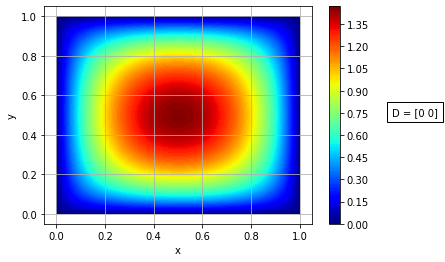

In [24]:
import matplotlib.pyplot as plt
import numpy as np


xy_plot = tp.domains.Parallelogram(X*Y, [0, 0], [w, 0], [0, h])
plot_sampler = tp.samplers.PlotSampler(xy_plot, n_points=1000, 
                                       data_for_other_variables={'D': [0,0]})##

fig = tp.utils.plot(model, constrain_fn, plot_sampler, plot_type="contour_surface")#
#name = str(round(i/3.0, 3)) + "," + str(round(j/3.0, 3))

#plt.title('D=[1,1]')
plt.savefig("figure33.png")
plt.show()


In [13]:
#xy_plot = tp.domains.Parallelogram(X*Y, [0, 0], [w, 0], [0, h])
#
#for i in [-3,-2,-1,0,1,2,3]:
#    for j in [-3,-2,-1,0,1,2,3]:
#        plot_sampler = tp.samplers.PlotSampler(xy_plot, n_points=1000, 
#                                       data_for_other_variables={'D': [i/3,j/3]})
#        fig = tp.utils.plot(model, constrain_fn, plot_sampler, plot_type="contour_surface")

In [25]:
# Ausgabe des Maximum der Lösung
N = 200

## Gitter erzeugen
xi = np.linspace(0,1,N)
yi = np.linspace(0,1,N)
XX, YY = np.meshgrid(xi, yi)

## In Tensor umwandeln
in_data = torch.zeros((N**2, 4))
in_data[:, :1]  = torch.tensor(XX).reshape(-1, 1)
in_data[:, 1:2] = torch.tensor(YY).reshape(-1, 1)
     
in_data[:, 2] = 0
in_data[:, 3] = 0

## Model laden und mit constrains kombinieren
out = model(tp.spaces.Points(in_data, X*Y*D)).as_tensor.detach()
out = constrain_fn(out, in_data[:, :1], in_data[:, 1:2])

print('Maximum = ',torch.max(out))

Maximum =  tensor(1.4604)


In [15]:
import matplotlib.pyplot as plt
import numpy as np

N = 100
levels = np.linspace(0.0, 1.5, 50)

## Gitter erzeugen
xi = np.linspace(0,1,N)
yi = np.linspace(0,1,N)
XX, YY = np.meshgrid(xi, yi)
Z = XX + YY

## In tensor umwandeln
in_data = torch.zeros((N**2, 4))
in_data[:, :1]  = torch.tensor(XX).reshape(-1, 1)
in_data[:, 1:2] = torch.tensor(YY).reshape(-1, 1)

## Plots erstellen
x11 = [0, 0.25, 0, -0.25, 0, 0.25, 0.5, 0.25, 0, -0.25, -0.5, -0.25, 0, 0.375, 0.75, 0.375 , 0, -0.375 ,-0.75, -0.375, 0, 0.6, 0.6, -0.6, -0.6]
y11 = [0,0, 0.25, 0, -0.25, -0.125, 0, 0.25, 0.5, 0.25, 0, -0.25, -0.5, -0.25, 0, 0.5, 1, 0.5 ,0, -0.5, -1, -0.75, 0.75, 0.75, -0.75]
s = 0
for j in range(len(x11)):     
        s = s+1
        in_data[:, 2] = x11[j]
        in_data[:, 3] = y11[j]
        
        plt.figure(figsize=(8, 5))
        out = model(tp.spaces.Points(in_data, X*Y*D)).as_tensor.detach()
        out = constrain_fn(out, in_data[:, :1], in_data[:, 1:2])
        CS = plt.contourf(xi, yi, out.reshape(N, N), cmap=plt.cm.jet, 
                          vmin=0.0, vmax=1.0, levels=levels)
        plt.colorbar(CS)
        plt.grid()
        plt.ylabel("y")
        plt.xlabel("x")
        plt.title("b = " + str(N))
        
        name = str(s)
        #plt.title("D = [" + name + "]")
        plt.savefig("plot_D_" + name + ".png")
        #plt.show()
        plt.close()

In [16]:
import imageio
images = []
s= 0

for i in range(25):
        s=s+1
        name = str(s)
        filename = "plot_D_" + name + ".png"
        images.append(imageio.imread(filename))
imageio.mimsave('test_movie.gif', images, loop = 0, duration = 500)

/tmp/ipykernel_36055/1881825803.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [17]:
torch.save(model.state_dict(), 'PDE.pt')

In [18]:
##Axen erstellen, um Viewpoint ändern zu können
#from mpl_toolkits.mplot3d import Axes3D
#ax = Axes3D(fig)

## Plots erstellen
x11 = [0, 0.25, 0, -0.25, 0, 0.25, 0.5, 0.25, 0, -0.25, -0.5, -0.25, 0, 0.375, 0.75, 0.375 , 0, -0.375 ,-0.75, -0.375, 0, 0.6, 0.6, -0.6, -0.6]
y11 = [0,0, 0.25, 0, -0.25, -0.125, 0, 0.25, 0.5, 0.25, 0, -0.25, -0.5, -0.25, 0, 0.5, 1, 0.5 ,0, -0.5, -1, -0.75, 0.75, 0.75, -0.75]
s = 0
for j in range(len(x11)):   
        s = s+1
        #Plotten
        #ax.view_init(elev=10, azim=(j+1)*(14/360))
        plot_sampler = tp.samplers.PlotSampler(plot_domain=xy_plot, n_points=2000, device='cuda',
                                       data_for_other_variables={ 'D': [x11[j],y11[j]]})
        fig = tp.utils.plot(model, constrain_fn, plot_sampler, plot_type="3D")
        #fig = tp.utils.ax.plot(model, constrain_fn, plot_sampler, plot_type="3D", elev=10, azim=(j+1)*(14/360),scene_camera=camera)
        #Speichern
        name = str(s)
        plt.savefig("plot_3D_" + name + ".png")
        plt.close()

In [19]:
import imageio
images = []
s= 0

for i in range(25):
        s=s+1
        name = str(s)
        filename = "plot_3D_" + name + ".png"
        images.append(imageio.imread(filename))
imageio.mimsave('test_movie3D.gif', images, loop = 0, duration = 500)

/tmp/ipykernel_36055/1254364634.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [20]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from matplotlib import cm
from matplotlib.ticker import LinearLocator

N = 100
levels = np.linspace(0.0, 1.5, 50)

## Gitter erzeugen
xi = np.linspace(0,1,N)
yi = np.linspace(0,1,N)
XX, YY = np.meshgrid(xi, yi)
Z = XX + YY

## In tensor umwandeln
in_data = torch.zeros((N**2, 4))
in_data[:, :1]  = torch.tensor(XX).reshape(-1, 1)
in_data[:, 1:2] = torch.tensor(YY).reshape(-1, 1)

## Plots erstellen
x11 = [0, 0.25, 0, -0.25, 0, 0.25, 0.5, 0.25, 0, -0.25, -0.5, -0.25, 0, 0.375, 0.75, 0.375 , 0, -0.375 ,-0.75, -0.375, 0, 0.6, 0.6, -0.6, -0.6]
y11 = [0,0, 0.25, 0, -0.25, -0.125, 0, 0.25, 0.5, 0.25, 0, -0.25, -0.5, -0.25, 0, 0.5, 1, 0.5 ,0, -0.5, -1, -0.75, 0.75, 0.75, -0.75]
s = 0
for j in range(len(x11)):     
        s = s+1
        in_data[:, 2] = x11[j]
        in_data[:, 3] = y11[j]
        
        ##Achsen und Plot erstellen:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        #fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ##Z-Werte erstellen:
        out = model(tp.spaces.Points(in_data, X*Y*D)).as_tensor.detach()
        out = constrain_fn(out, in_data[:, :1], in_data[:, 1:2])
        ##Z-Werte in Plot schicken
        CS = ax.plot_surface(XX, YY, out.reshape(N,N),cmap=cm.jet)
        
        ##Legende für Z-Werte
        #fig.colorbar(CS) #shrink=0.5, aspect=5
        ax.view_init(elev=20, azim=j*14)
        ##Optionen des Plots
        #plt.grid()
        #plt.ylabel("y")
        #plt.xlabel("x")
        #plt.title("b = " + str(x11[j]) + "," + str(y11[j]))
        ax.set_title("b = " + str(x11[j]) + "," + str(y11[j]))
        ##Speichern der Bilder
        name = str(s)
        #plt.title("D = [" + name + "]")
        plt.savefig("plot_3D_rotierend_" + name + ".png")
        #plt.show()
        plt.close()

In [21]:
import imageio
images = []
s= 0

for i in range(25):
        s=s+1
        name = str(s)
        filename = "plot_3D_rotierend_" + name + ".png"
        images.append(imageio.imread(filename))
imageio.mimsave('test_movie3D_rotierend.gif', images, loop = 0, duration = 500)

/tmp/ipykernel_36055/2964717738.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [22]:
# Ausgabe des Maximum der Lösung
N = 200

## Gitter erzeugen
xi = np.linspace(0,1,N)
yi = np.linspace(0,1,N)
XX, YY = np.meshgrid(xi, yi)

## In Tensor umwandeln
in_data = torch.zeros((N**2, 4))
in_data[:, :1]  = torch.tensor(XX).reshape(-1, 1)
in_data[:, 1:2] = torch.tensor(YY).reshape(-1, 1)
     
in_data[:, 2] = 0
in_data[:, 3] = 0

## Model laden und mit constrains kombinieren
out = model(tp.spaces.Points(in_data, X*Y*D)).as_tensor.detach()
out = constrain_fn(out, in_data[:, :1], in_data[:, 1:2])

print('Maximum = ',torch.max(out))

Maximum =  tensor(1.4602)
